# RDataFrame
[RDataFrame documentation](https://root.cern/doc/master/classROOT_1_1RDataFrame.html)

`RDataFrame` is high-level interface recommended by ROOT to perform the analysis, which is officially part of ROOT. 

The framework loads `TTree` into a table and handles loop management over event entries. This allows users to easily specify custom code executed within the event loop, making the analysis efficiently parallelizable.
What you need to do is add a line `ROOT.EnableImplicitMT()`.

Moreover, It is adapted for HEP languages: `C++` and `Python`.

## Create a ROOT RDataFrame
First of all, we can construct a `RDataFrame` by specifying the name of a tree and one or more files.

In [1]:
import ROOT

# scale all the available cores locally
# enable multi-threading with the specified amount of threads
ROOT.EnableImplicitMT()

# df = ROOT.RDataFrame("tree_name", "file_name")
# or 
# df = ROOT.RDataFrame("tree_name", ["file1_name", "file2_name", .....])
df = ROOT.RDataFrame("Events", "DYToLL.root")

Welcome to JupyROOT 6.28/04


It has a special function called `Describe` to show the contents of tree(s).

In [2]:
df.Describe().Print()

Dataframe from TChain Events in file DYToLL.root

Property                Value
--------                -----
Columns in total         1719
Columns from defines        0
Event loops run             0
Processing slots            4

Column                                                                                                  Type                            Origin
------                                                                                                  ----                            ------
BeamSpot_sigmaZ                                                                                         Float_t                         Dataset
BeamSpot_sigmaZError                                                                                    Float_t                         Dataset
BeamSpot_type                                                                                           Char_t                          Dataset
BeamSpot_z                                         

## Discard unwanted events for this analysis 
Generally, Ntuple needs to do the objects and events selections to get the events for the actual analysis. We can use the functions `Define` and `Filter` to do the objects and events selections. 
 1. `Define`: To create custom columns. This function is useful to define a collection past the object selection.
 2. `Filter`: To discrad unwanted events (i.e. apply event cuts). 

The function `Define` relies on the operation on a `std::vector`-like collection `ROOT::VecOps::RVec<T>`.
For loop is no longer needed from our side. We only need the operation like this to have `ele_pt > 10`.
```
ele_pt[ele_pt > 10.f]
```
<img src="RVec.png" width="1000" height="600">

For more information about `RVec` please check 
[RVec documentation](https://root.cern/doc/master/classROOT_1_1VecOps_1_1RVec.html).


Here, we consider electrons satisfying some very basic criteria
 1. Electron_mvaIso_WP90
 2. pT > 10 GeV

and two electrons with opposite charges will be selected to reconstruct Z mass.

| Branch name | Data type | Description|
|-------------|-----------|------------|
| `nElectron` | `UInt_t` | Number of electrons (slimmedElectrons after basic selection (pt > 5 ))
| `Electron_pt` | `ROOT::VecOps::RVec<Float_t>` | Pt stored as vector with length `nElectron`|
| `Electron_eta` | `ROOT::VecOps::RVec<Float_t>` | Eta stored as vector with length `nElectron`|
| `Electron_phi` | `ROOT::VecOps::RVec<Float_t>` | Phi stored as vector with length `nElectron`|
| `Electron_charge` | `ROOT::VecOps::RVec<Float_t>` | Electric charge stored as vector with length `nElectron` (1 or -1)|
| `Electron_mass` | `ROOT::VecOps::RVec<Float_t>` | Mass stored as vector with length `nElectron`|
| `Electron_mvaIso_WP90` | `ROOT::VecOps::RVec<Bool_t>` | MVA Iso ID WP90 stored as vector with length `nElectron`|


Traditionally, we need to loop over every event and object to select the events we want.
Just as the python script shown belows.
```
import ROOT
fin = ROOT.TFile.Open("ntuple.root", "READ")
tin = fin.Get("tree_name")

for ev in tin:
    if (len(ev.nElectron) < 1):
        continue
    
    good_ele = []
    for iele in range(len(ev.nElectron)):
        if (ev.Electron_mvaIso_WP90[iele] != 1 || ev.Electron_pt[iele] < 10):
            continue
        good_ele.append(iele)
    
    if (len(ev.nElectron) < 1):
        continue

    ......
```
How will the above thing be done in `RDataFrame` approach?

In [3]:
df1 = df.Filter("ROOT::VecOps::Sum(nElectron) > 1", "nele > 1")
        .Define("isGoodEle", "Electron_mvaIso_WP90 == 1 && Electron_pt > 10")\
        .Filter("ROOT::VecOps::Sum(isGoodEle) > 1", "two good electrons")

However, world is not that simple. Sometimes we need a complicated operation to extract the "good" objects.

Here, for example, we want to get the exact indices of the most energetic two electrons pass the crieria (i.e. defined as isGoodEle)

RDataFrame provides two methods to deal with this condition. One injects `C++ expression`, and the other one uses `Numba` together with `numpy.array`.

In [4]:
import numpy as np

def my_init():
    @ROOT.Numba.Declare(["RVec<int>", "RVec<float>"], "RVec<int>")
    def GetIndices(isgood, pt): # the RVec will be treated as numpy array in the function
        idx_select = np.nonzero(isgood)[0]
        idx_sort = np.argsort(-pt)
        idx = np.array([i for i in idx_sort if i in idx_select], dtype=np.int32)
        return idx
    
    # this method also works
    # ROOT.gInterpreter.Declare("""
    #     #ifndef MYHELP
    #     #define MYHELP
    #     ROOT::RVec<int> GetIndices(const ROOT::RVec<int>& isgood, const ROOT::RVec<float>& pt){
    #         ROOT::RVec<int> idx_select = ROOT::VecOps::Nonzero(isgood);
    #         ROOT::RVec<int> idx_sort = ROOT::VecOps::Reverse(ROOT::VecOps::Argsort(pt));
    #         ROOT::RVec<int> idx = ROOT::VecOps::Intersect(idx_sort, idx_select);
    #         return idx;
    #     }
    #     #endif
    # """)
my_init()

Once these two electrons are selected, we can further require their charges should be opposite and reconstruct the 4-vectors `ROOT::Math::LorentzVector`.

You might be more familiar with the `TLorentzVector` class, but it's now deprecated by ROOT. The newly developed `ROOT::Math::LorentzVector` offers improved performance and maintains a very similar usage to the `TLorentzVector`.

For more information about `ROOT::Math::LorentzVector` please check 
[ROOT::Math::LorentzVector documentation](https://root.cern.ch/doc/master/classROOT_1_1Math_1_1LorentzVector.html).

In [5]:
df2 = df1.Define("ele1_idx", "Numba::GetIndices(isGoodEle, Electron_pt)[0]")\
         .Define("ele2_idx", "Numba::GetIndices(isGoodEle, Electron_pt)[1]")\
         .Filter("Electron_charge[ele1_idx] * Electron_charge[ele2_idx] < 0", "opposite charge")\
         .Define("ele1",      "ROOT::Math::PtEtaPhiMVector v(Electron_pt[ele1_idx], Electron_eta[ele1_idx], Electron_phi[ele1_idx], Electron_mass[ele1_idx]); return v;")\
         .Define("ele2",      "ROOT::Math::PtEtaPhiMVector v(Electron_pt[ele2_idx], Electron_eta[ele2_idx], Electron_phi[ele2_idx], Electron_mass[ele2_idx]); return v;")\
         .Define("diEleMass", "(float) (ele1+ele2).M()")

## Produce the results

The function `Histo1D` returns a one-dimensional histogram `TH1D` wrapped by smart pointer, so calling it is the same as what you need to do when initializing a `TH1D`.

`RDataFrame` also supports users to export the columns to various `ROOT` objects, like
1. `Profile1D` fills a one-dimensional `TProfile`.
2. `Graph` fills a `TGraph` with the two columns provided.

In addition, the function `Report` can produce the cut flow report. It calculates how many event entries have been accepted and rejected by the filters passed to the `Filter` method.

Users can also dump the results in to a smaller `TTree` to do a furhter study via `SnapShot`.

Notably, The event loop is triggerd when we try to access the histogram object. (i.e. call the funtion of `TH1`)
This is because several actions metioned above in `RDataFrame` are computed lazily.
Therefore, make sure all transformations and actions are booked berfore you access the contents of any objects. 
This enable `RDataFrame` to produce all the results at the same time.

<cppyy.gbl.ROOT.RDF.RResultPtr<ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void> > object at 0x55c6000e12a0>

two good electrons: pass=1253       all=10000      -- eff=12.53 % cumulative eff=12.53 %
opposite charge: pass=1226       all=1253       -- eff=97.85 % cumulative eff=12.26 %


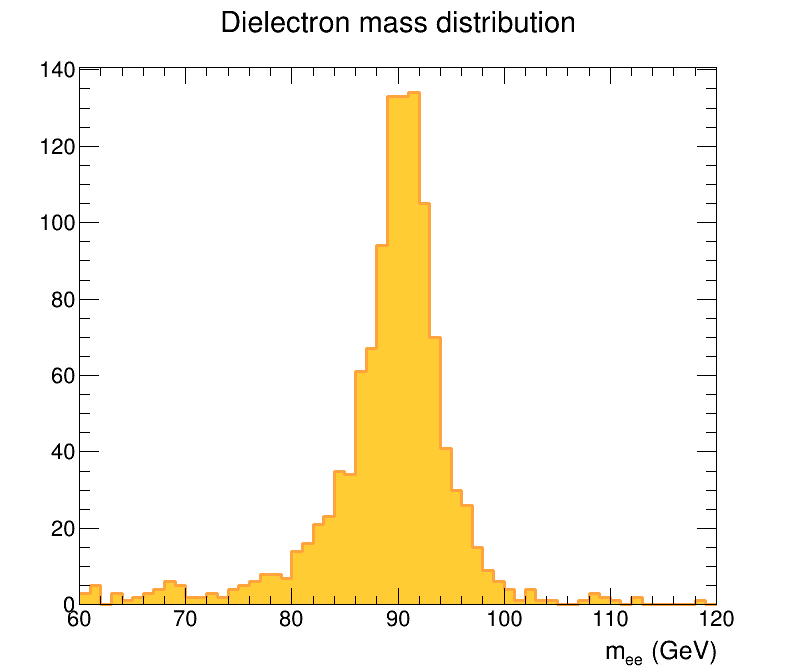

In [6]:
report = df2.Report()
hist = df2.Histo1D(("diEleMass", "Dielectron mass distribution", 60, 60, 120), "diEleMass") 

ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetPadTickX(1)
ROOT.gStyle.SetPadTickY(1)    
c = ROOT.TCanvas("c", "c", 800, 700)
c.cd()

# trigger the event loop
hist.GetXaxis().SetTitle("m_{ee} (GeV)")
hist.GetXaxis().SetTitleSize(0.04)
hist.GetXaxis().SetTitleOffset(1.1)
hist.SetLineColor(ROOT.TColor.GetColor("#FFA33C")) 
hist.SetFillColor(ROOT.TColor.GetColor("#FFC436")) 
hist.SetLineWidth(3)
hist.Draw("hist")

c.Draw()
report.Print()

# Snapshot("tree_name", "file_name", [all the colums you want to save])
df2.Snapshot("miniTree", "miniTree.root", ["ele1", "ele2", "diEleMass"])

In [7]:
%%bash 
root -l miniTree.root
miniTree->Print()


Attaching file miniTree.root as _file0...
(TFile *) 0x560992a004e0
******************************************************************************
*Tree    :miniTree  : miniTree                                               *
*Entries :     1226 : Total =           92426 bytes  File  Size =      38716 *
*        :          : Tree compression factor =   2.25                       *
******************************************************************************
*Branch  :ele1                                                               *
*Entries :     1226 : BranchElement (see below)                              *
*............................................................................*
*Br    0 :fCoordinates :                                                     *
*Entries :     1226 : Total  Size=       2964 bytes  One basket in memory    *
*Baskets :        0 : Basket Size=      32000 bytes  Compression=   1.00     *
*..............................................................

## Distributed RDataFrame

The `RDataFrame` metioned above is executed locally, which meas that your resource are restricted by the cores of the single machine. 
Benefit from Dask, we can use distributed RDataFrame to to scale up the analysis across cores of the multiple machines (clusters).

The distributed RDataFrame has similar usage as local RDataFrame, so users don't need to change the analysis code.

**What users need to do is to create the connection to the cluster and plug it into the distributed `RDataFrame`.**

Here, we use `Dask.LocalCluster` to demonstrate it. 
Please check [distrdf002_dask_connection.py](https://root.cern.ch/doc/master/distrdf002__dask__connection_8py.html) for more information.

In [8]:
from dask.distributed import LocalCluster, Client
from dask_jobqueue import HTCondorCluster


def my_init_dist():
    @ROOT.Numba.Declare(["RVec<int>", "RVec<float>"], "RVec<int>")
    def GetIndices_dist(isgood, pt): # the RVec will be treated as numpy array in the function
        idx_select = np.nonzero(isgood)[0]
        idx_sort = np.argsort(-pt)
        idx = np.array([i for i in idx_sort if i in idx_select], dtype=np.int32)
        return idx


def create_connection():
    # cluster = HTCondorCluster(
    #     cores=1,
    #     memory="3000MB",  
    #     disk="2000MB",
    #     job_extra_directives={
    #         "log": "dask_job.log",
    #         "output": "dask_job.out",
    #         "error": "dask_job.err"
    #         # "should_transfer_files": "Yes",
    #         # "when_to_transfer_output": "ON_EXIT"
    #     }
    # )
    # cluster.scale(jobs=4)
    cluster = LocalCluster(n_workers=4, threads_per_worker=1, processes=True, memory_limit="2GiB")
    client = Client(cluster)
    return client

DistRDF = ROOT.RDF.Experimental.Distributed.Dask.RDataFrame
initialize = ROOT.RDF.Experimental.Distributed.initialize
initialize(my_init_dist)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


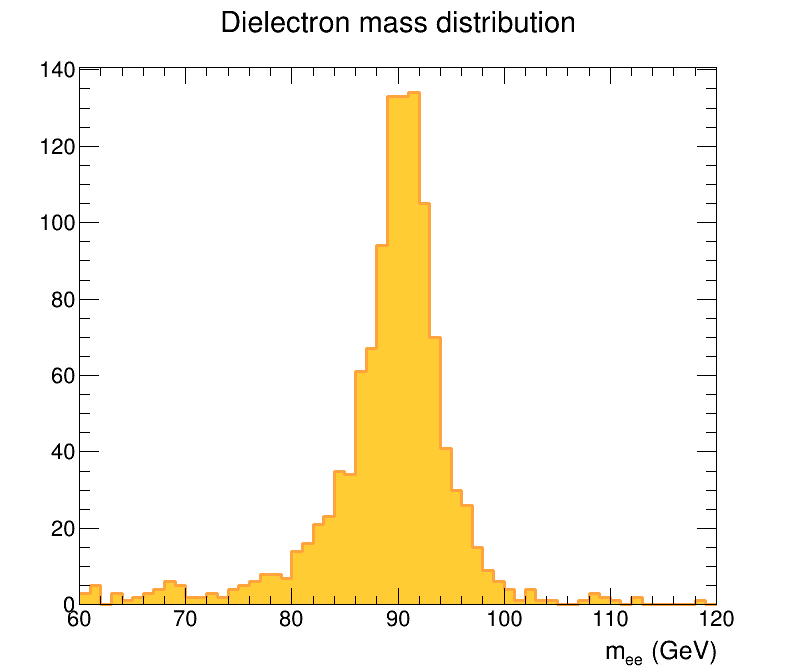

In [9]:
client = create_connection()
df_dist = DistRDF("Events", "DYToLL.root", daskclient=client)

df1_dist = df_dist.Define("isGoodEle", "Electron_mvaIso_WP90 == 1 && Electron_pt > 10")\
                  .Filter("ROOT::VecOps::Sum(isGoodEle) > 1", "two good electrons")
        
df2_dist = df1_dist.Define("ele1_idx", "Numba::GetIndices_dist(isGoodEle, Electron_pt)[0]")\
                   .Define("ele2_idx", "Numba::GetIndices_dist(isGoodEle, Electron_pt)[1]")\
                   .Filter("Electron_charge[ele1_idx] * Electron_charge[ele2_idx] < 0", "opposite charge")\
                   .Define("ele1",      "ROOT::Math::PtEtaPhiMVector v(Electron_pt[ele1_idx], Electron_eta[ele1_idx], Electron_phi[ele1_idx], Electron_mass[ele1_idx]); return v;")\
                   .Define("ele2",      "ROOT::Math::PtEtaPhiMVector v(Electron_pt[ele2_idx], Electron_eta[ele2_idx], Electron_phi[ele2_idx], Electron_mass[ele2_idx]); return v;")\
                   .Define("diEleMass", "(float) (ele1+ele2).M()")

hist_dist = df2_dist.Histo1D(("diEleMass", "Dielectron mass distribution", 60, 60, 120), "diEleMass") 

ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetPadTickX(1)
ROOT.gStyle.SetPadTickY(1)    
c = ROOT.TCanvas("c", "c", 800, 700)
c.cd()

# trigger the event loop
hist_dist.GetXaxis().SetTitle("m_{ee} (GeV)")
hist_dist.GetXaxis().SetTitleSize(0.04)
hist_dist.GetXaxis().SetTitleOffset(1.1)
hist_dist.SetLineColor(ROOT.TColor.GetColor("#FFA33C")) 
hist_dist.SetFillColor(ROOT.TColor.GetColor("#FFC436")) 
hist_dist.SetLineWidth(3)
hist_dist.Draw("hist")

c.Draw()

In [10]:
client.close()